In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [72]:
from datasets import load_dataset
from irls_optimizer import IRLS
from Adam import AdamOptim
from SGD import SGD
from Logreg import LogisticRegression 
from utils import fitComparisonModels, createFeatureInteractions

from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

np.seterr(divide = 'ignore') 
np.seterr(invalid='ignore')
np.seterr(over ='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

# Blood (small dataset)

In [57]:
ds = load_dataset("mstz/blood")

Xy = ds["train"].with_format("pandas")[:]
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]
Xy.head()

,months_since_last_donation,total_donation,total_blood_donated_in_cc,has_donated_last_month
0,2,50,12500,1
1,0,13,3250,1
2,1,16,4000,1
3,2,20,5000,1
4,1,24,6000,0


In [58]:
def optimizer_factory(name, **kwargs):
    if name == "irls":
        return IRLS()
    elif name == "adam":
        return AdamOptim(**kwargs)
    elif name == "sgd":
        return SGD(**kwargs)
    else:
        raise ValueError("irls, adam and sgd only supported")

Running irls


Epoch::  11%|█         | 11/100 [00:00<00:05, 16.71it/s]


Early stopping after epoch 11
Reverting to the weights corresponding to the lowest validation loss
(array([0., 1.]), array([468,  10]))
0.7442307692307693
[0. 1.]
0.7142857142857142


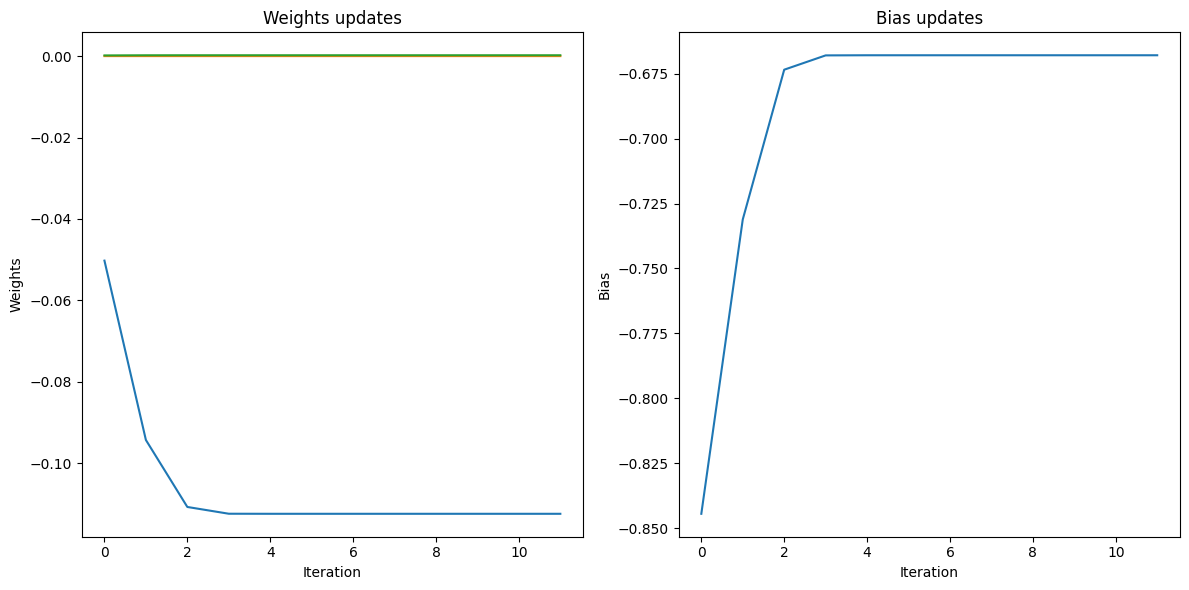

Running adam


Epoch::  10%|█         | 10/100 [00:00<00:00, 1004.50it/s]

Early stopping after epoch 10
Reverting to the weights corresponding to the lowest validation loss
(array([0.]), array([478]))
0.7782426778242678
[0.]
0.7533333333333333



/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


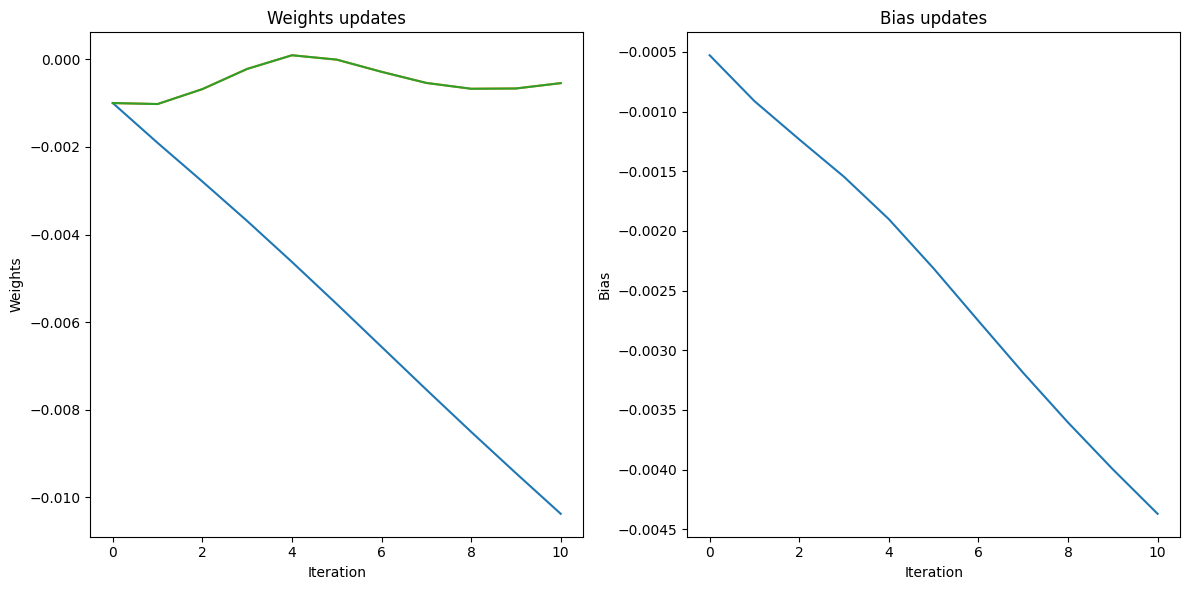

Running sgd


Epoch::   4%|▍         | 4/100 [00:00<00:00, 748.52it/s]

Early stopping after epoch 4
Reverting to the weights corresponding to the lowest validation loss
(array([0.]), array([478]))
0.7782426778242678
[0.]
0.7533333333333333



/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


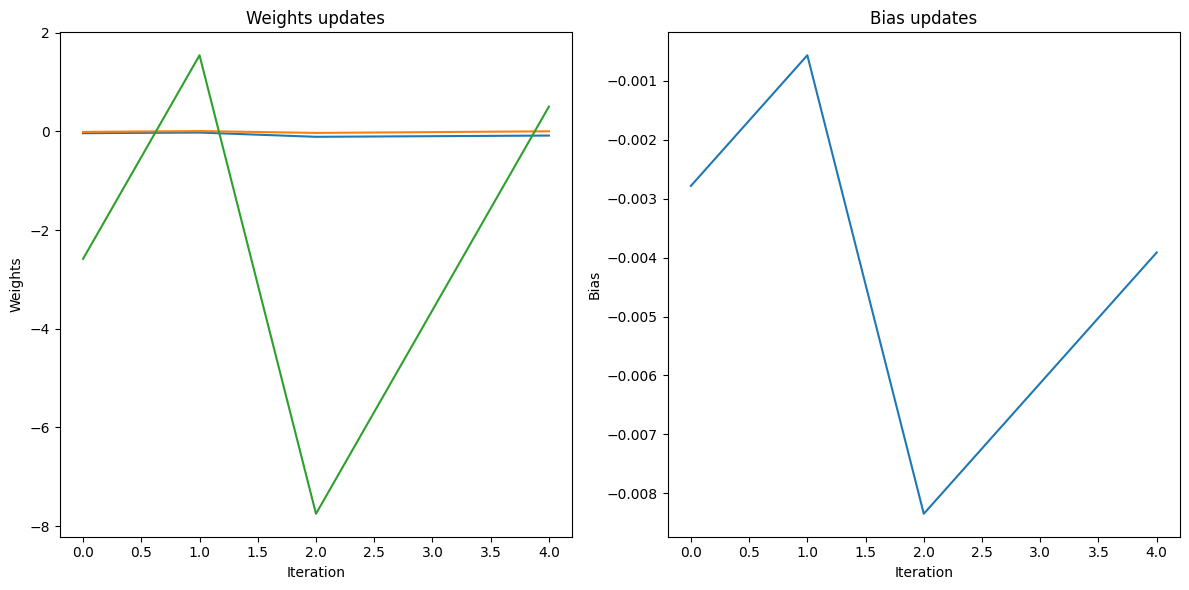

0.5090887347524515
0.5010762975364745
0.613250418560153
0.5771346567806745


/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [59]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

optimizer = IRLS()
optimizer_to_kwargs = {"irls": {}, "adam": {"eta": 0.001}, "sgd": {"eta": 0.01}}
for optimizer_name, kwargs in optimizer_to_kwargs.items():
    print(f"Running {optimizer_name}")
    optimizer = optimizer_factory(optimizer_name, **kwargs)
    log_reg = LogisticRegression(input_dim=X_train.shape[1])
    log_reg.train(X_train, y_train, X_val=X_val, y_val=y_val, optimizer=optimizer, patience=5, epochs=100, batch_size=X_train.shape[0])
    
    y_pred_train=log_reg.predict(X_train).round()
    print(np.unique(y_pred_train, return_counts=True))
    print(balanced_accuracy_score(y_pred_train, y_train))
    y_pred = log_reg.predict(X_test)
    print(np.unique(y_pred.round()))
    print(balanced_accuracy_score(y_pred.round(), y_test))
    log_reg.plot_params()
# Other models
y_lda, y_qda, y_dt, y_rf = fitComparisonModels(X_train, y_train, X_test)
lda_ba = balanced_accuracy_score(y_test, y_lda)
print(lda_ba)
qda_ba = balanced_accuracy_score(y_test, y_qda)
print(qda_ba)
qda_dt = balanced_accuracy_score(y_test, y_dt)
print(qda_dt)
qda_rf = balanced_accuracy_score(y_test, y_rf)
print(qda_rf)

# Blood (small dataset) with interactions

In [ ]:
seed = 42

X_int = createFeatureInteractions(X.values)
X_train, X_test, y_train, y_test = train_test_split(X_int, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

optimizer = IRLS()
optimizer_to_kwargs = {"irls": {}, "adam": {"eta": 0.001}, "sgd": {"eta": 0.01}}
for optimizer_name, kwargs in optimizer_to_kwargs.items():
    print(f"Running {optimizer_name}")
    optimizer = optimizer_factory(optimizer_name, **kwargs)
    log_reg = LogisticRegression(input_dim=X_train.shape[1])
    log_reg.train(X_train, y_train, X_val=X_val, y_val=y_val, optimizer=optimizer, patience=5, epochs=100, batch_size=X_train.shape[0])
    
    y_pred_train=log_reg.predict(X_train).round()
    print(np.unique(y_pred_train, return_counts=True))
    print(balanced_accuracy_score(y_pred_train, y_train))
    y_pred = log_reg.predict(X_test)
    print(np.unique(y_pred.round()))
    print(balanced_accuracy_score(y_pred.round(), y_test))
    log_reg.plot_params()
# Other models
y_lda, y_qda, y_dt, y_rf = fitComparisonModels(X_train, y_train, X_test)
lda_ba = balanced_accuracy_score(y_test, y_lda)
print(lda_ba)
qda_ba = balanced_accuracy_score(y_test, y_qda)
print(qda_ba)
qda_dt = balanced_accuracy_score(y_test, y_dt)
print(qda_dt)
qda_rf = balanced_accuracy_score(y_test, y_rf)
print(qda_rf)

Running irls


Epoch::   0%|          | 0/100 [00:00<?, ?it/s]

# UCI Shopper (big dataset)

In [60]:
ds = load_dataset("jlh/uci-shopper")

Xy = ds["train"].with_format("pandas")[:]
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]
Xy.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,0


In [61]:
oe = OrdinalEncoder()
oe_cols = ["Month", "VisitorType", "Weekend"]
oe.fit(X[oe_cols])
X[oe_cols] = oe.transform(X[oe_cols])

# seed = 42
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

Running irls


Epoch::   8%|▊         | 8/100 [00:07<01:21,  1.13it/s]

Early stopping after epoch 8
Reverting to the weights corresponding to the lowest validation loss
(array([0., 1.]), array([7291,  600]))
0.8357716134046541
[0. 1.]
0.7993090133116554


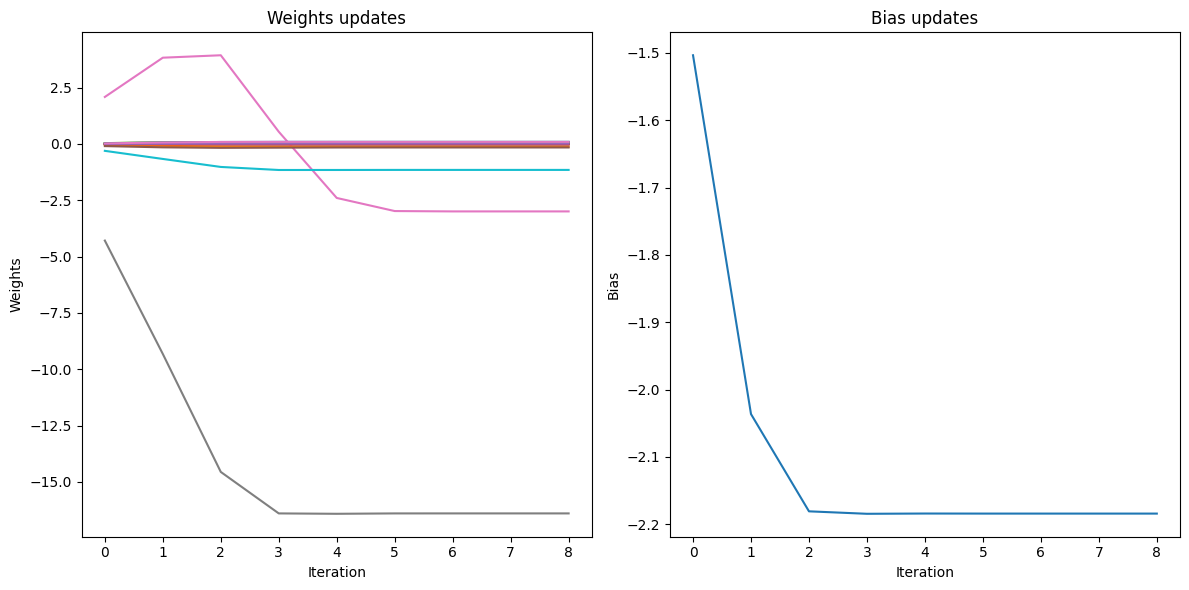

Running adam


Epoch::  13%|█▎        | 13/100 [00:00<00:03, 22.77it/s]

Early stopping after epoch 13
Reverting to the weights corresponding to the lowest validation loss
(array([0., 1.]), array([7688,  203]))
0.8673554974036692
[0. 1.]
0.8876652268942549


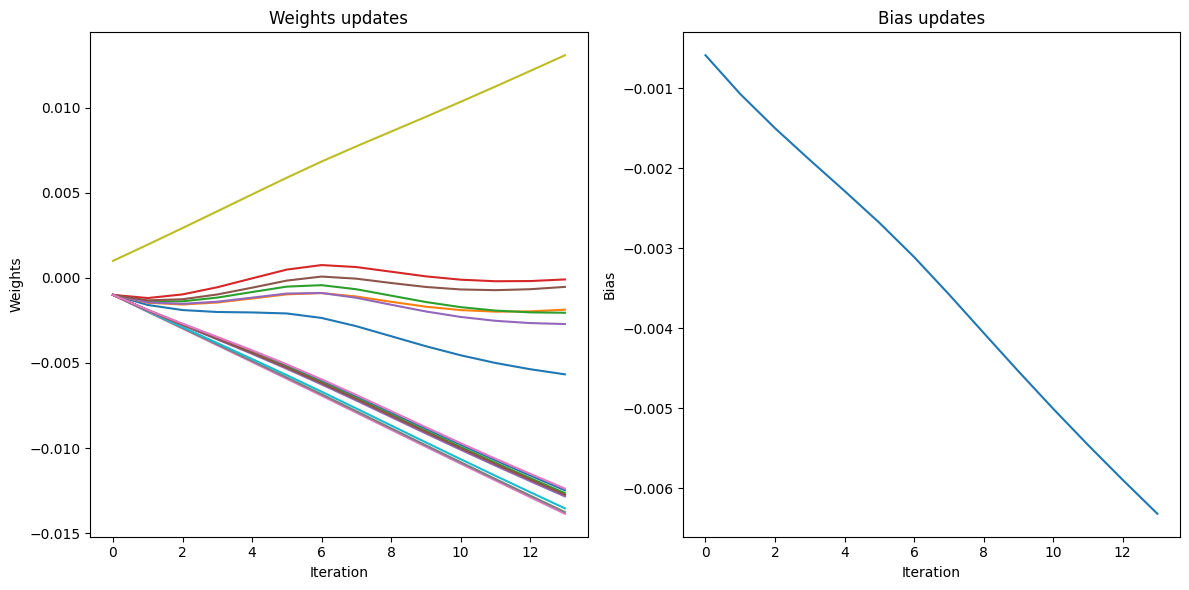

Running sgd


Epoch::   4%|▍         | 4/100 [00:00<00:06, 13.73it/s]
/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Early stopping after epoch 4
Reverting to the weights corresponding to the lowest validation loss
(array([0.]), array([7891]))
0.8488151058167532
[0.]
0.8333333333333334


/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


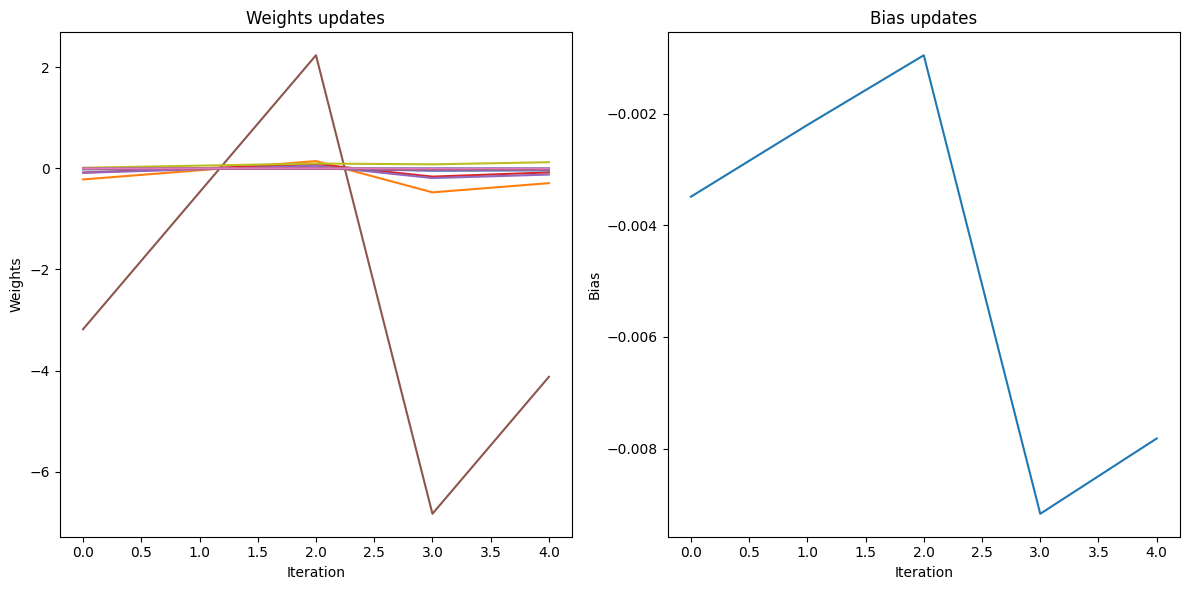

0.6450121654501216
0.7440389294403893
0.721411192214112
0.7532846715328467


In [62]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

optimizer = IRLS()
optimizer_to_kwargs = {"irls": {}, "adam": {"eta": 0.001}, "sgd": {"eta": 0.01}}
for optimizer_name, kwargs in optimizer_to_kwargs.items():
    print(f"Running {optimizer_name}")
    optimizer = optimizer_factory(optimizer_name, **kwargs)
    log_reg = LogisticRegression(input_dim=X_train.shape[1])
    log_reg.train(X_train, y_train, X_val=X_val, y_val=y_val, optimizer=optimizer, patience=5, epochs=100, batch_size=X_train.shape[0])
    
    y_pred_train=log_reg.predict(X_train).round()
    print(np.unique(y_pred_train, return_counts=True))
    print(balanced_accuracy_score(y_pred_train, y_train))
    y_pred = log_reg.predict(X_test)
    print(np.unique(y_pred.round()))
    print(balanced_accuracy_score(y_pred.round(), y_test))
    
    log_reg.plot_params()
    
# Other models
y_lda, y_qda, y_dt, y_rf = fitComparisonModels(X_train, y_train, X_test)
lda_ba = balanced_accuracy_score(y_test, y_lda)
print(lda_ba)
qda_ba = balanced_accuracy_score(y_test, y_qda)
print(qda_ba)
qda_dt = balanced_accuracy_score(y_test, y_dt)
print(qda_dt)
qda_rf = balanced_accuracy_score(y_test, y_rf)
print(qda_rf)

# mstz/heart_failure (big dataset)

In [63]:
from datasets import load_dataset

ds = load_dataset("mstz/heart_failure")

Xy = ds["train"].with_format("pandas")[:]
Xy.head()

,age,has_anaemia,creatinine_phosphokinase_concentration_in_blood,has_diabetes,heart_ejection_fraction,has_high_blood_pressure,platelets_concentration_in_blood,serum_creatinine_concentration_in_blood,serum_sodium_concentration_in_blood,is_male,is_smoker,days_in_study,is_dead
0,75,False,582.0,False,20.0,True,265000.00,1.9,130.0,True,False,4,1
1,55,False,7861.0,False,38.0,False,263358.03,1.1,136.0,True,False,6,1
2,65,False,146.0,False,20.0,False,162000.00,1.3,129.0,True,True,7,1
3,50,True,111.0,False,20.0,False,210000.00,1.9,137.0,True,False,7,1
4,65,True,160.0,True,20.0,False,327000.00,2.7,116.0,False,False,8,1


In [64]:
oe_cols = ["has_anaemia", "has_diabetes", "has_high_blood_pressure", "is_male", "is_smoker"]
oe = OrdinalEncoder()
oe.fit(Xy.loc[:, oe_cols])
Xy.loc[:, oe_cols] = oe.transform(Xy[oe_cols])
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]
X.head()

,age,has_anaemia,creatinine_phosphokinase_concentration_in_blood,has_diabetes,heart_ejection_fraction,has_high_blood_pressure,platelets_concentration_in_blood,serum_creatinine_concentration_in_blood,serum_sodium_concentration_in_blood,is_male,is_smoker,days_in_study
0,75,0.0,582.0,0.0,20.0,1.0,265000.00,1.9,130.0,1.0,0.0,4
1,55,0.0,7861.0,0.0,38.0,0.0,263358.03,1.1,136.0,1.0,0.0,6
2,65,0.0,146.0,0.0,20.0,0.0,162000.00,1.3,129.0,1.0,1.0,7
3,50,1.0,111.0,0.0,20.0,0.0,210000.00,1.9,137.0,1.0,0.0,7
4,65,1.0,160.0,1.0,20.0,0.0,327000.00,2.7,116.0,0.0,0.0,8


Running irls


Epoch::  15%|█▌        | 15/100 [00:00<00:03, 21.32it/s]


Early stopping after epoch 15
Reverting to the weights corresponding to the lowest validation loss
(array([0., 1.]), array([133,  58]))
0.8240212600466683
[0. 1.]
0.8444444444444444


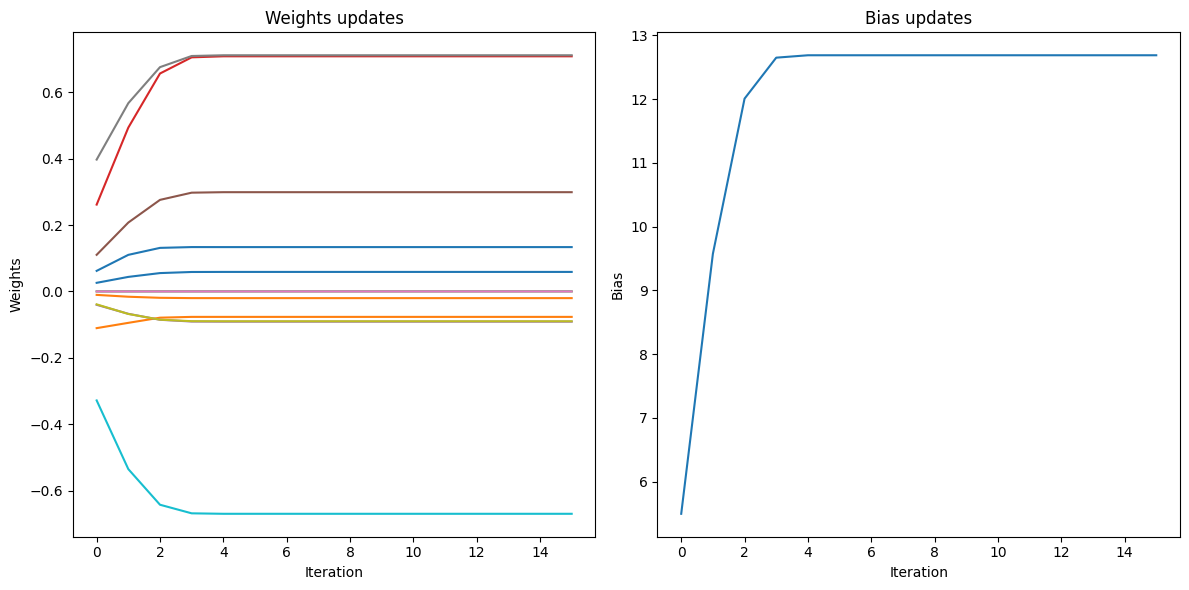

Running adam


Epoch::   7%|▋         | 7/100 [00:00<00:00, 586.56it/s]

Early stopping after epoch 7
Reverting to the weights corresponding to the lowest validation loss
(array([0.]), array([191]))
0.675392670157068
[0.]
0.5833333333333334



/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


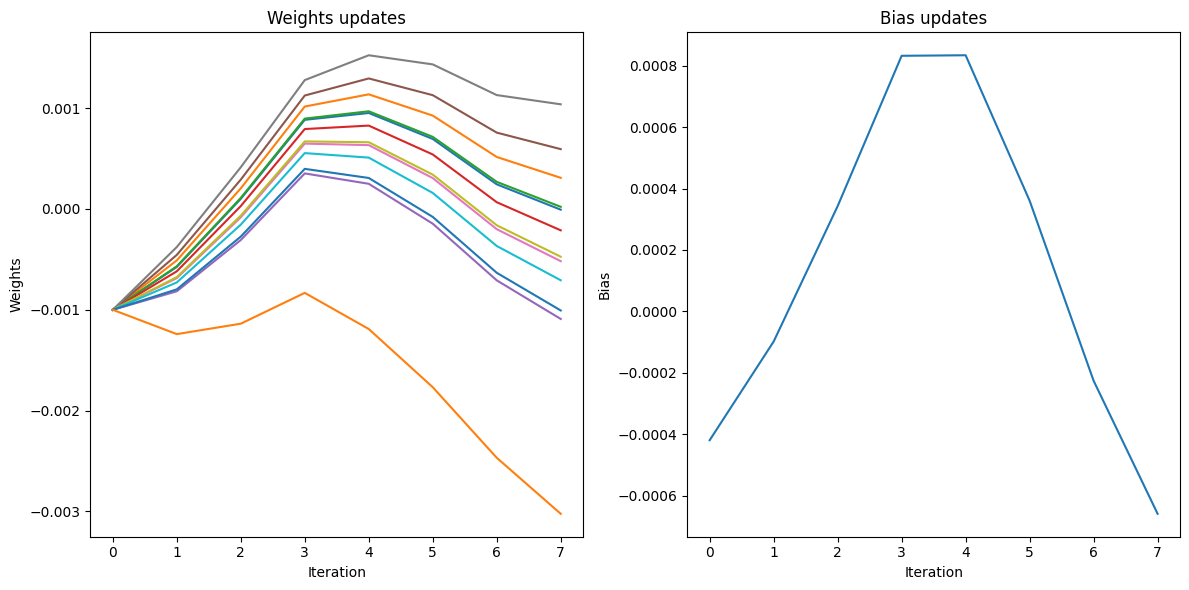

Running sgd


Epoch::   4%|▍         | 4/100 [00:00<00:00, 487.03it/s]

Early stopping after epoch 4
Reverting to the weights corresponding to the lowest validation loss
(array([0.]), array([191]))
0.675392670157068
[0.]
0.5833333333333334



/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/adam/.pyenv/versions/3.10.9/envs/flwr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


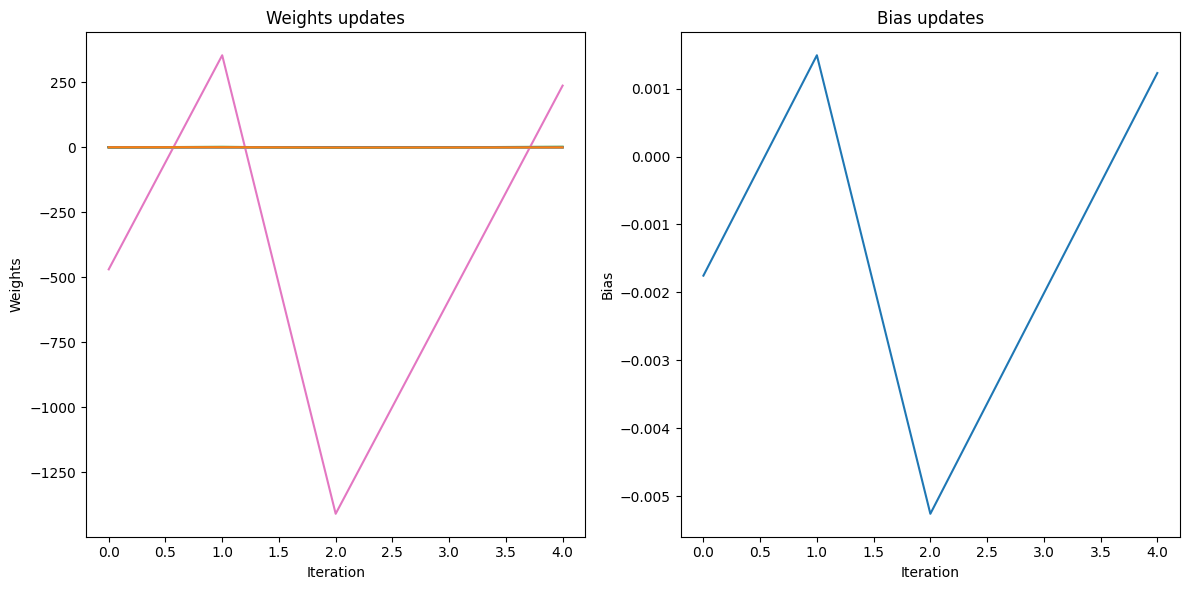

0.7657142857142858
0.6228571428571428
0.6657142857142857
0.6628571428571428


In [65]:
seed = 42
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

optimizer_to_kwargs = {"irls": {}, "adam": {"eta": 0.001}, "sgd": {"eta": 0.01}}
for optimizer_name, kwargs in optimizer_to_kwargs.items():
    print(f"Running {optimizer_name}")
    optimizer = optimizer_factory(optimizer_name, **kwargs)
    log_reg = LogisticRegression(input_dim=X_train.shape[1])
    log_reg.train(X_train, y_train, X_val=X_val, y_val=y_val, optimizer=optimizer, patience=5, epochs=100, batch_size=X_train.shape[0])
    
    y_pred_train=log_reg.predict(X_train).round()
    print(np.unique(y_pred_train, return_counts=True))
    print(balanced_accuracy_score(y_pred_train, y_train))
    y_pred = log_reg.predict(X_test)
    print(np.unique(y_pred.round()))
    print(balanced_accuracy_score(y_pred.round(), y_test))
    
    log_reg.plot_params()
    
# Other models
y_lda, y_qda, y_dt, y_rf = fitComparisonModels(X_train, y_train, X_test)
lda_ba = balanced_accuracy_score(y_test, y_lda)
print(lda_ba)
qda_ba = balanced_accuracy_score(y_test, y_qda)
print(qda_ba)
qda_dt = balanced_accuracy_score(y_test, y_dt)
print(qda_dt)
qda_rf = balanced_accuracy_score(y_test, y_rf)
print(qda_rf)

# To be removed mstz/mushroom

In [66]:
ds = load_dataset("mstz/mushroom")

Xy = ds["train"].with_format("pandas")[:]
oe = OrdinalEncoder()
oe.fit(Xy)
Xy[:] = oe.transform(Xy)
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.head()

,cap_shape,cap_surface,cap_color,has_bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,...,stalk_surface_belows_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,number_of_rings,ring_type,spore_print_color,population,habitat
0,2.0,3.0,0.0,1.0,7.0,1.0,0.0,1.0,0.0,0.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,0.0,3.0,4.0
1,2.0,3.0,9.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,1.0,2.0,0.0
2,0.0,3.0,8.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,1.0,2.0,2.0
3,2.0,2.0,8.0,1.0,7.0,1.0,0.0,1.0,1.0,0.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,0.0,3.0,4.0
4,2.0,3.0,3.0,0.0,6.0,1.0,1.0,0.0,0.0,1.0,...,2.0,7.0,7.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0


In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
# corr_matrix = np.corrcoef(X_train, rowvar=False)

# # Step 2: Identify collinear features
# threshold = 0.9  # Example threshold
# upper_tri_indices = np.triu_indices_from(corr_matrix, k=1)

# collinear_pairs = [(row, col) for row, col in zip(*upper_tri_indices)
#                    if abs(corr_matrix[row, col]) > threshold]

# # Step 3: Remove one feature from each pair of collinear features
# # Note: This example removes the first feature in each pair arbitrarily
# to_remove = set(row for row, _ in collinear_pairs)

In [69]:
# correlation_matrix = np.corrcoef(X_train, rowvar=False)
# high_correlation = np.where((np.abs(correlation_matrix) > 0.95) & (np.eye(correlation_matrix.shape[0]) == 0))

# # Remove one feature from each highly correlated pair
# to_remove = set()
# for i in range(len(high_correlation[0])):
#     # Choose one index to remove, e.g., the second in each pair
#     to_remove.add(high_correlation[1][i])

Epoch::  24%|██▍       | 24/100 [00:17<00:55,  1.37it/s]

Early stopping after epoch 24
Reverting to the weights corresponding to the lowest train loss
0.9429242520457861
0.9413841572328379


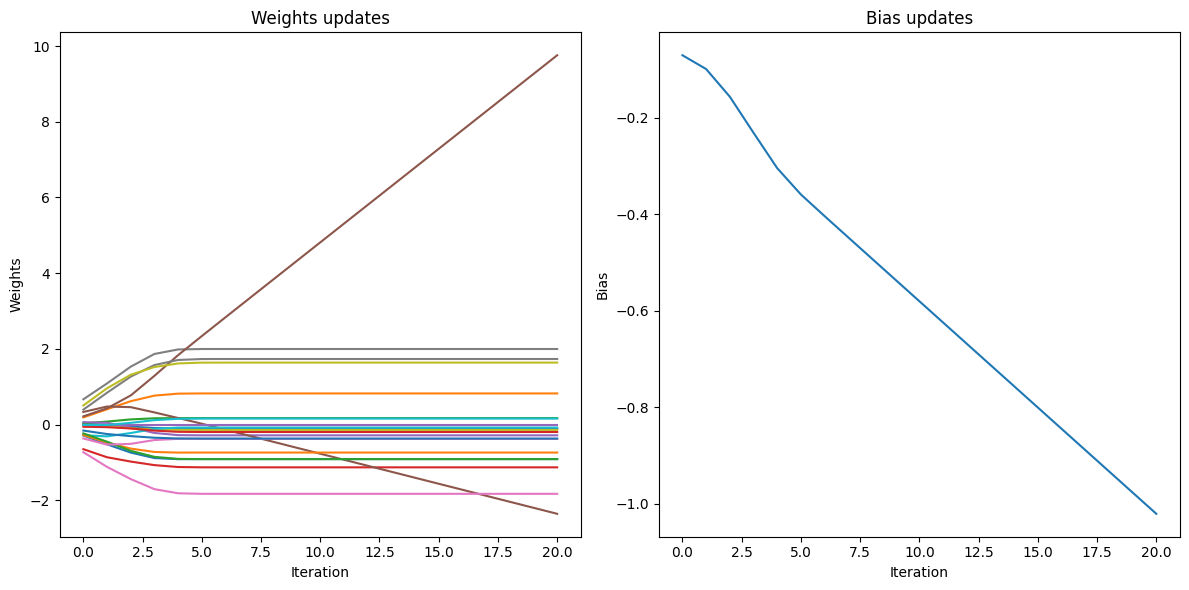

In [70]:
irls = IRLS()

log_reg = LogisticRegression(input_dim=X_train.shape[1])
log_reg.train(X_train, y_train, optimizer=irls, patience=5, epochs=100, batch_size=X_train.shape[0])

y_pred_train=log_reg.predict(X_train).round()
print(balanced_accuracy_score(y_pred_train, y_train))
y_pred = log_reg.predict(X_test)
print(balanced_accuracy_score(y_pred.round(), y_test))

log_reg.plot_params()

In [71]:
log_reg.weights_updates

[array([ 1.55702038e-02,  1.88349032e-01,  3.32935392e-02, -6.50335555e-01,
         6.28451881e-02,  3.32944382e-01, -7.29576912e-01,  6.66998963e-01,
        -1.34829890e-02, -2.80801925e-01, -2.88257499e-01, -2.76666329e-01,
        -2.32738105e-01, -5.81490120e-02,  1.36868330e-15,  2.16795373e-01,
        -3.67797550e-01,  3.94086078e-01,  5.04858420e-01, -9.63290232e-03,
        -1.58552088e-01]),
 array([-6.23023548e-03,  4.02748377e-01,  7.85670130e-02, -8.63779994e-01,
         4.72422904e-02,  4.76354924e-01, -1.11842371e+00,  1.08664043e+00,
        -4.98442614e-02, -3.11789228e-01, -5.21554800e-01, -4.74466124e-01,
        -4.53458991e-01, -6.91236130e-02, -1.90871007e-16,  4.28643511e-01,
        -5.30658463e-01,  8.41186142e-01,  9.58611828e-01, -1.22708847e-02,
        -2.50242034e-01]),
 array([-5.38828358e-02,  6.17183335e-01,  1.36145533e-01, -9.77628873e-01,
        -7.92355093e-02,  4.59958357e-01, -1.43996291e+00,  1.52926268e+00,
        -9.93429691e-02, -2.230887